<a href="https://colab.research.google.com/github/Tawheed-tariq/Machine-learning-course/blob/main/simple%20projects/malaria%20diagnosis/malaria_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Layer, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2, L1
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint


In [5]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files= True, split = ['train'])

In [6]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [7]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))

  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [8]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset , val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Data Visualization

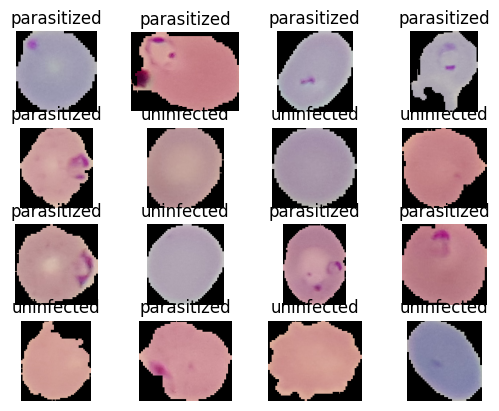

In [9]:
for i , (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data preprocessing

In [10]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255.0, label

In [11]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [12]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model Creation and Training

In [15]:
dropout_rate = 0.2
regularizing_rate = 0.01
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu', kernel_regularizer = L2(regularizing_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Dropout(rate = dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu', kernel_regularizer = L2(regularizing_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    Dense(100, activation = 'relu', kernel_regularizer = L2(regularizing_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),
    Dense(10, activation = 'relu', kernel_regularizer = L2(regularizing_rate)),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      6

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
x = Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)
x = Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "feature_extractor")
feature_extractor_model.summary()


In [ ]:
feature_extractor_seq = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
])
feature_extractor_seq.summary()

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
# x = feature_extractor_model(func_input)
x = feature_extractor_seq(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name = "lenet_Model")
lenet_model_func.summary()


# Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, padding, strides, activation, pool_size):
    super(FeatureExtractor, self).__init__()
    self.conv1 = Conv2D(filters = filters , kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)
    self.bn1 = BatchNormalization()
    self.maxpool1 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

    self.conv2 = Conv2D(filters = 2*filters , kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)
    self.bn2 = BatchNormalization()
    self.maxpool2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self, x, training):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.maxpool2(x)
    return x

feature_sub_classed = FeatureExtractor(8, 3, 'valid', 1, 'relu', 2)


In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
x = feature_sub_classed(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name = "lenet_Model")
lenet_model_func.summary()


In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    self.feature_extractor = FeatureExtractor(8, 3, 'valid', 1, 'relu', 2)

    self.flatten = Flatten()
    self.dense1 = Dense(100, activation = 'relu')

    self.bn1 = BatchNormalization()
    self.dense2 = Dense(10, activation = 'relu')
    self.bn2 = BatchNormalization()

    self.dense3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)

    x = self.flatten(x)

    x = self.dense1(x)
    x = self.bn1(x)

    x = self.dense2(x)
    x = self.bn2(x)

    x = self.dense3(x)
    return x

lenet_subclassed_model = LenetModel()
lenet_subclassed_model(tf.zeros([1, 224, 224, 3]), training = False)
lenet_subclassed_model.summary()

# Callbacks

In [16]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\n for epoch number {epoch} the model has loss of {logs["loss"]}')
    def on_batch_end(self, batch, logs):
        print(f'\n for batch number {batch} the model has loss of {logs}')

## CSV Logger

In [17]:
csv_callback = CSVLogger(
    'logs.csv',
    separator = ',',
    append = False
)

## Early Stopping

In [18]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta = 0, patience = 2, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = False
)

## Learning Rate Schedular

In [19]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

scheduler_callack = LearningRateScheduler(scheduler, verbose = 1)

## Model Checkpointing

In [20]:
checkpoint_callback = ModelCheckpoint(
    'ceheckpoints/', mode = 'auto', monitor = 'val_loss', save_best_only = True, save_weights_only = False, save_freq = 'epoch', verbose = 1
)

# Model Training

In [21]:
metrics = [TruePositives(name= 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'),
           BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc')]

In [22]:
model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

In [23]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks = [scheduler_callack, checkpoint_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
689/689 [==============================] - ETA: 0s - loss: 3.7063 - tp: 8694.0000 - fp: 2942.0000 - tn: 8082.0000 - fn: 2328.0000 - accuracy: 0.7610 - precision: 0.7472 - recall: 0.7888 - auc: 0.8382
Epoch 1: val_loss improved from inf to 3.03384, saving model to ceheckpoints/
689/689 [==============================] - 73s 79ms/step - loss: 3.7063 - tp: 8694.0000 - fp: 2942.0000 - tn: 8082.0000 - fn: 2328.0000 - accuracy: 0.7610 - precision: 0.7472 - recall: 0.7888 - auc: 0.8382 - val_loss: 3.0338 - val_tp: 345.0000 - val_fp: 13.0000 - val_tn: 1346.0000 - val_fn: 1051.0000 - val_accuracy: 0.6138 - val_precision: 0.9637 - val_recall: 0.2471 - val_auc: 0.6165 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10
689/689 [==============================] - ETA: 0s - loss: 1.8323 - tp: 10322.0000 - fp: 1557.0000 - tn: 9466.0000 - fn: 701.0000 - accuracy:

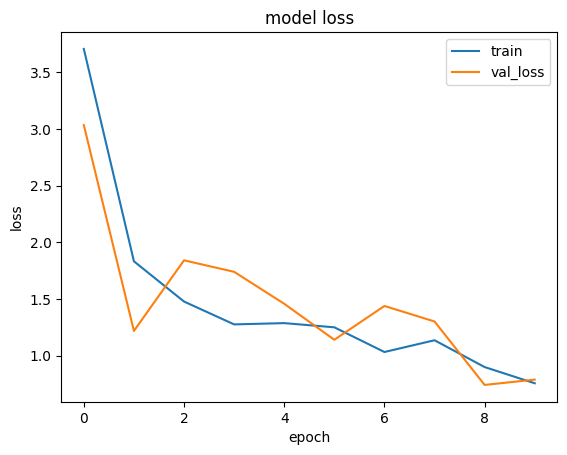

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val_loss'])
plt.show()

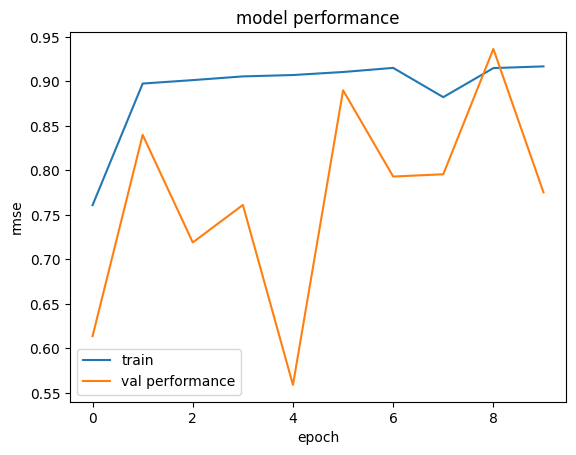

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model performance')
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.legend(['train', 'val performance'])
plt.show()

# Model Evaluation and Testing

In [26]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [27]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
test_dataset = test_dataset.batch(1)

In [29]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [31]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 29s 6ms/step - loss: 0.7895 - tp: 758.0000 - fp: 42.0000 - tn: 1348.0000 - fn: 609.0000 - accuracy: 0.7639 - precision: 0.9475 - recall: 0.5545 - auc: 0.9555


[0.7895057201385498,
 758.0,
 42.0,
 1348.0,
 609.0,
 0.7638737559318542,
 0.9474999904632568,
 0.5544989109039307,
 0.9555389285087585]

In [32]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.5456939

# Visualizing Confusion matrix

In [33]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [34]:
print(np.array(inp).shape)
print(np.array(inp)[:,0, ...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [35]:
labels = np.array([i[0] for i in labels])

In [36]:
labels

array([1, 1, 1, ..., 1, 1, 0])

In [38]:
predicted = model.predict(np.array(inp)[:,0, ...])
predicted[:, 0]

87/87 [==============================] - 2s 16ms/step


array([0.5224193 , 0.52590543, 0.49801603, ..., 0.4868576 , 0.51596326,
       0.03044783], dtype=float32)

[[1308   85]
 [  96 1268]]


Text(0.5, 58.7222222222222, 'predicted')

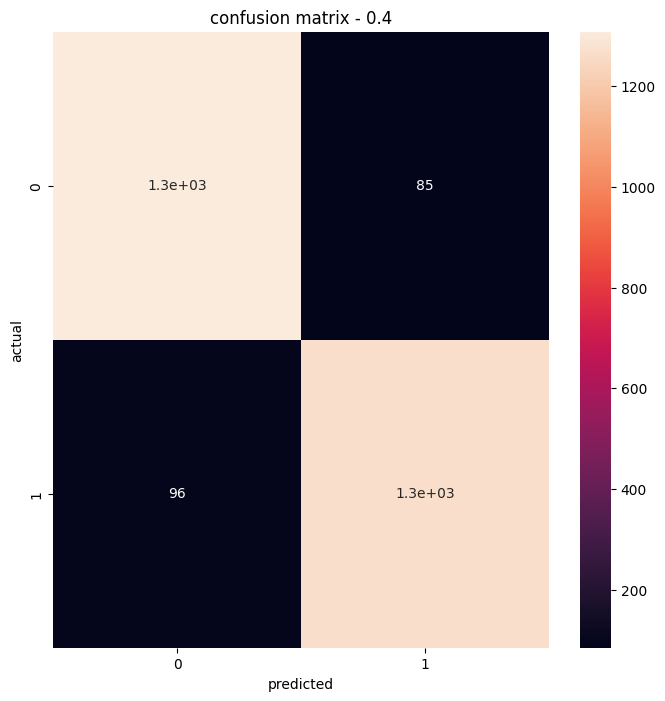

In [44]:
threshold = 0.4

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot=True)
plt.title('confusion matrix - {}'.format(threshold))
plt.ylabel('actual')
plt.xlabel('predicted')


# ROC plot

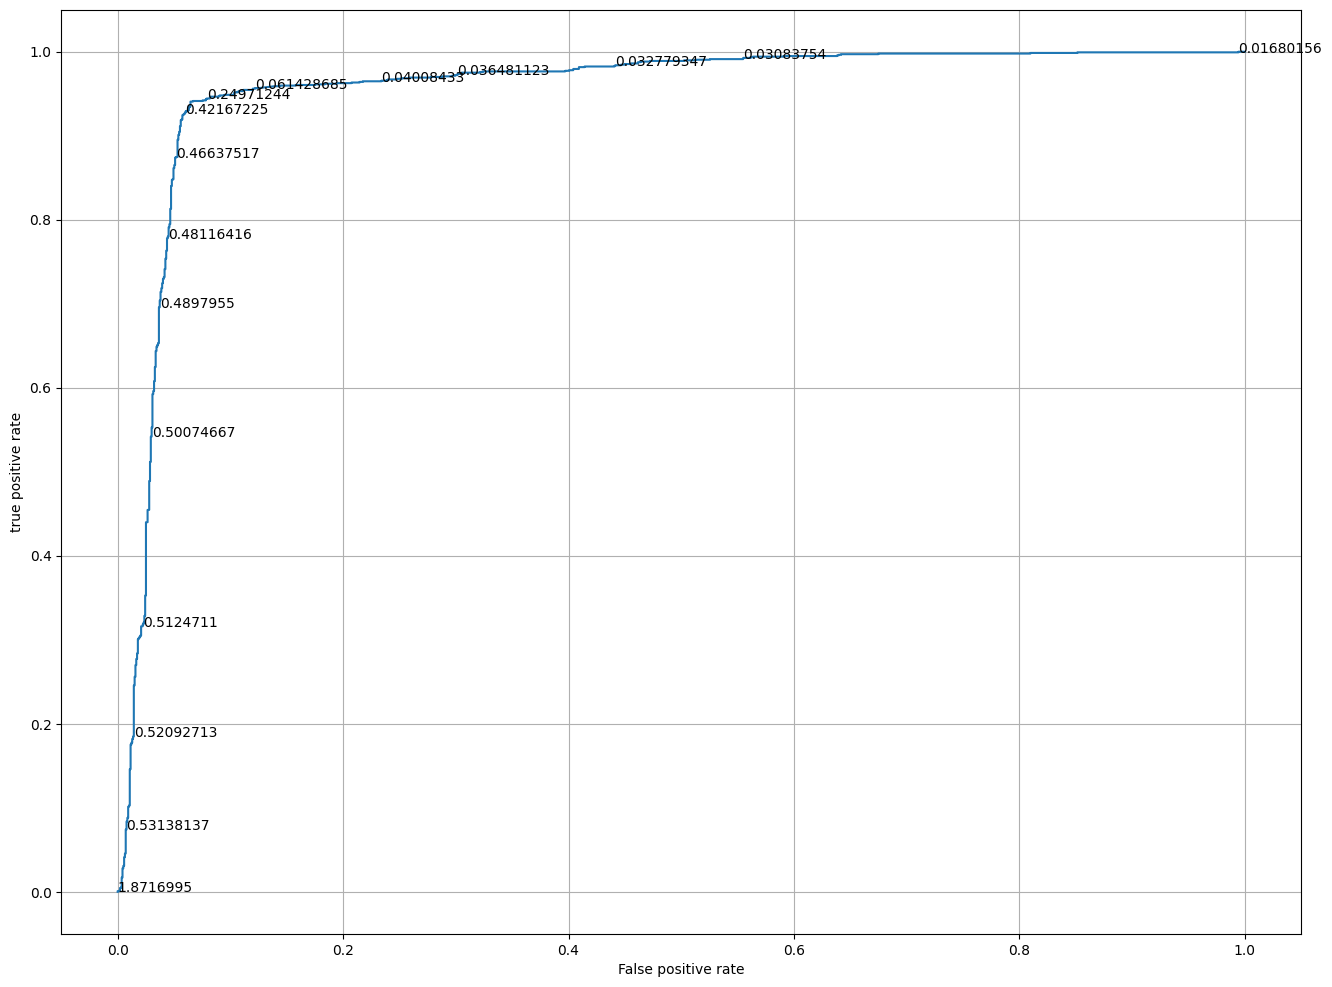

In [45]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.figure(figsize=(16, 12))
plt.plot(fp, tp)
plt.xlabel('False positive rate')
plt.ylabel('true positive rate')
plt.grid()

skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
plt.show()

In [46]:
def parasite_or_not(x):
  if(x < 0.5):
    return 'P'
  else:
    return 'U'

In [47]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])


1/1 [==============================] - 12s 12s/step


'U'

1/1 [==============================] - 0s 21ms/step


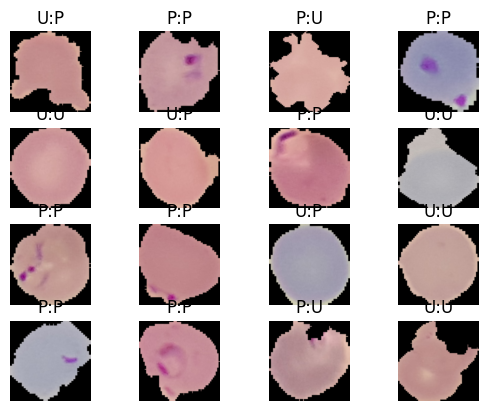

In [48]:
for i , (image, label) in enumerate(test_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [ ]:
# model.save('malaria_diagnosis.keras')